# Procesamiento de Trayectorias
## Ejemplo del análisis de trayectorias

<br>
<div style='background-color: #FC9188; padding: 10px; font-size: 15px;'>Este Notebook muestra un ejemplo cómo se cargarán y procesarán cada una de las trayectorias evaluadas en próximos notebooks.</div>

Cargamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

In [2]:
prot_name = 'cdk2'

In [3]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS.json')))[0]
                      
df_prot = pd.read_json(path_to_json_file)

Residuos de referencia para generar los resultados.  
En este análisis, por ahora sólo usaremos los residuos de Pisani.

In [4]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")

pocket_residues = get_pocket_residues(sep=",")

In [5]:
mask_pisani = F"(:{pisiani_residues})&(@CA)"

mask_pocket = F"(:{pocket_residues})&(@CA)"

# MDS de las estructuras de Referencia
<h3 class='text-danger'>Corresponde al MDS usando las 402 estructuras cristalográficas de la proteína</h3>

Para la proyección de puntos en el espacio de los cristales primero debemos obtener dicho espacio.
- Se carga la trayectoria con pytraj, únicamente los átomos de la proteína.
- Sólo para asegurarnos:
    - Se superpone la trayectoria primero con respecto al primer frame.
    - Luego se calcula la estructura promedio tras la superposición.
    - Luego se superpone toda la trayectoria a esa estructura promedio.

In [6]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = os.path.join("..", "..", "ARCHIVOS", "CRISTALES", 
                                  "TRAJ_CRISTALS_PDB", "PDB_402_cdk2_PISANI_ALL.pdb")
# Por ahora cargamos tods los átomos, sumiendo que en algun momento necesitaremos todos los átomos
traj_crystals = pyt.load(file_pdb_traj_pisani)
# Nos aseguramos de superponer la trayectoria a una estructura promedio
# NOTA: prody realiza esta optimización iterando hasta minimizar el rmsd con el método superpose
# no obstante, las pruebas hechas muestran que el impacto es mínimo 
# pues incluso omitiendo las siguientes tres líneas el mds es el msimo
traj_crystals = traj_crystals.superpose()[mask_pisani]
avg_ref_traj = pyt.mean_structure(traj_crystals)
pyt.superpose(traj_crystals, ref = avg_ref_traj)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 117.


### Cálculo de la matriz de RMSD
<div class="alert alert-block alert-danger">
    <p><b>OJO:</b> No se usa la máscara porque directamente la hemos proporcionado ya al cargar la trayectoria con los átomos seleccionados a modo de <i>slicing</i>.</p>
 
</div>

#### MDS Pisani

In [10]:
# Obtenemos el MDS usando la subsecuencia de pisani y las 402 estructuras
rmsd_402_crys = pyt.pairwise_rmsd(traj = traj_crystals, metric="rms")

#### MDS Pocket residues

In [7]:
# Superponemos usando la máscara de los residuos del pocket
traj_crystals_pk = pyt.load(file_pdb_traj_pisani)
traj_crystals_pk = traj_crystals_pk.superpose()[mask_pocket]
avg_ref_traj_pk = pyt.mean_structure(traj_crystals_pk)
pyt.superpose(traj_crystals_pk, ref = avg_ref_traj_pk)

print(F'Número de frames: {traj_crystals_pk.n_frames}.\nNúmero de átomos: {traj_crystals_pk.n_atoms}.')

Número de frames: 402.
Número de átomos: 40.


In [8]:
# Obtenemos el MDS usando la subsecuencia del pocket y las 402 estructuras
rmsd_402_crys_pk = pyt.pairwise_rmsd(traj = traj_crystals_pk, metric="rms")

### Realizamos el MDS con Pisani
Este MDS considera las  402 estructuras cirstalográficas, pero toma en cuenta los residuos reportados por **Pisani (2016).**

In [11]:
from modules.MDS import cMDS, cMDS_proj
# Llevamos a cabo el mds
mds_pisani_402 = cMDS(rmsd_402_crys)

**Guardamos el objeto MDS_PISANI_402** para no tener que calcularlo de nuevo. Lo usaremos más tarde.

In [9]:
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
if not os.path.exists(path_mds_obj):
    import pickle
    with open(path_mds_obj, 'wb') as f:
        pickle.dump(mds_pisani_402, f)
else: print('The file exist!')

The file exist!


### Realizamos el MDS con Pisani

In [12]:
from modules.MDS import cMDS, cMDS_proj
# Llevamos a cabo el mds
mds_pocket_402 = cMDS(rmsd_402_crys_pk)

In [14]:
path_mds_obj_pk = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pocket_402_obj.pyobj')
if not os.path.exists(path_mds_obj_pk):
    import pickle
    with open(path_mds_obj_pk, 'wb') as f:
        pickle.dump(mds_pocket_402, f)
else: print('The file exist!')

<h3> Visualizamos la proyección definida por las <span class='text-danger'>estructuras cristalográficas</span></h2>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'white')
from modules.plotting_functions import plot_points, plot_anotation_labels

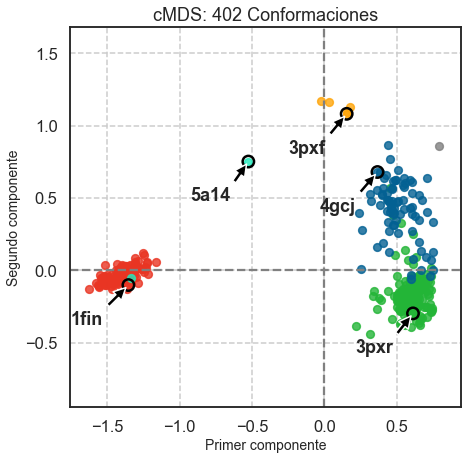

In [11]:
mds_plot = mds_pisani_402
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_plot[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), mds_plot[0][0], mds_plot[0][1], 
                      xytext_delta=[0.4, 0.3], s=130)

## Definimos dos funciones para procesar las trayectorias:

In [12]:
from miscellanious_traj_functions import process_pca, get_sup_points_projected_mds

In [13]:
projection_example = \
        get_sup_points_projected_mds(MDS_ref_object = mds_pisani_402, 
              traj_reference = traj_crystals, 
              # Las consf de prueba son un subconjunto de las de referencia
              traj_out_of_sample = traj_crystals[::2], 
              ref = 0, n_components = 2)

### Visualizamos la proyección de los mismo puntos

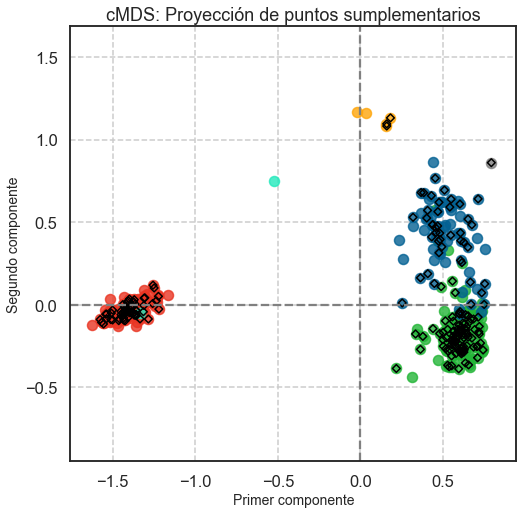

In [14]:
# Se genera la gráfica de ejmplo de proyección
fig = plt.figure(figsize=(8, 8))
plot_points(mds = mds_pisani_402[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: Proyección de puntos sumplementarios", point_size = 100)
# Proyección de los puntos "out of sample"
plt.scatter(projection_example[0], projection_example[1], marker = 'D', 
            c = 'None', edgecolors='black', s = 30);

<p class="p-5 border bg-success font-weight-bold">Los puntos suplementarios son proyectados correctamente.</p>

# Comenzamos el análisis de una trayectoria

## Proteína CDK2: 4fku
**Conformación apo -  SA/Solventes mixtos**

Definimos el directorio de las dinámicas.

In [15]:
DM_DIR =  os.path.join('..', '..', 'ARCHIVOS', 'DINAMICA')

### Carga de la trayectoria
**Path de los archivos:**

In [16]:
system = '4fku'
md_type = 'mxs_sa'
file_basename = 'mxs_cdk2'
rep = 'rep_5'
# Definimos el path del archivo prmtop y del rst7, el rst7 funciona como la conforamción de
# refeencia al ser la conformación cristalográfica
ref_conf_4fku_path_rst7 = \
    os.path.join(DM_DIR, system, md_type, rep, F'{file_basename}.rst7')
ref_conf_4fku_path_prmtop = \
    os.path.join(DM_DIR, system, md_type, rep, F'{file_basename}.prmtop')

# Ahora definimos los paths de minimización, SA, equilibrado y producción
# minimización, sólo se guardó un rst7
min_conf_4fku = \
    os.path.join(DM_DIR, system, md_type, rep, '1_min', F'{file_basename}_min_all.rst7')

# SA, Eq y Producción
sa_traj_4fku, eq_traj_4fku, prod_traj_4fku = \
    glob.glob(os.path.join(DM_DIR, system, md_type, rep, '*/', F'{file_basename}*.nc'))

# Lista de archivos
traj_list_4fku_paths = [ref_conf_4fku_path_rst7, min_conf_4fku, sa_traj_4fku, eq_traj_4fku, prod_traj_4fku]

print('La trayectoria será cargada en este orden:')
for i in traj_list_4fku_paths:
    print(i)

La trayectoria será cargada en este orden:
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_5/mxs_cdk2.rst7
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_5/1_min/mxs_cdk2_min_all.rst7
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_5/2_term/mxs_cdk2_term.nc
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_5/3_eq/mxs_cdk2_eq.nc
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_5/4_prod/mxs_cdk2_prod.nc


Con los archivos definidos arriba, usamos pytraj.iterload() para cargar todas las conformaciones:
1. **Referencia (rst7):** 1 frame, archivo de cordenadas iniciales.
- **Minimización (rst7):** 1 frame, archivo de coordanadas tras minimización con solvente explícito.
- **Simulate Annealing/Termalización:** 300 frames, trayectoria de 3 ns (a 1 fs/paso) del calentamiento/SA.
- **Equilibrado:** 250 frames,trayectoria de 5 ns (2 ns/paso( del equilibrado.
- **Producción:** 1000 frames, trayectoria de producción de 20 ns (2 ns/paso).

In [17]:
trajs_iterator_4fku = pyt.iterload(traj_list_4fku_paths, top = ref_conf_4fku_path_prmtop)
trajs_iterator_4fku

pytraj.TrajectoryIterator, 1552 frames: 
Size: 1.471476 (GB)
<Topology: 42418 atoms, 11334 residues, 11037 mols, PBC with box type = truncoct>
           

Podemos contabilizar el número de frames:
> Para ello leemos las trayectorias por fase de forma independiente.  
No usamos pyt.load() para no cargar las trayectorias en memoria, sólo nos interesa saber el número de frames.

### Rangos de frames para cada fase de la dinámica

In [18]:
list_n_frames = [pyt.iterload(traj, top = ref_conf_4fku_path_prmtop).n_frames
                 for traj in traj_list_4fku_paths]
list_name_phases = ['crys', 'min', 'sa', 'eq', 'prod']

first = 0
# Diccionario con los rangos de frames pertenecientes a cada fase
dic_n_frames_by_phase = {}
for phase, n_frames in zip(list_name_phases, list_n_frames):
    last =  first + n_frames
    dic_n_frames_by_phase[phase] = range(first, last)
    first = last
    
for i, j in dic_n_frames_by_phase.items():
    print(F'{i.upper()}: \t{len(j)} frames')

CRYS: 	1 frames
MIN: 	1 frames
SA: 	300 frames
EQ: 	250 frames
PROD: 	1000 frames


Aplicamos la máscara de Pisani y nos quedamos sólo con los CA de su lista de residuos. Esto a su vez convierte el objeto pytraj.Trajectoryiterator() a pytraj.Trajectory().

In [19]:
traj_full_4fku = trajs_iterator_4fku[mask_pisani]
traj_full_4fku

pytraj.Trajectory, 1552 frames: 
Size: 0.004059 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, PBC with box type = truncoct>
           

## Calculamos el RMSD de la trayectoria

In [20]:
rmsd_full_traj = pyt.rmsd(traj_full_4fku, ref = 0)

## PCA
### Trayectoria Total y Producción
Sólo para poner en perspectiva cómo afectan los frames de fases fuera de la producción al aproyección de puntos en el PCA.

In [21]:
pca_full_traj = process_pca(traj_full_4fku, ref = 0, n_vecs = 2)
pca_prod_traj = process_pca(traj_full_4fku[ -1000:], ref = 0, n_vecs = 2)

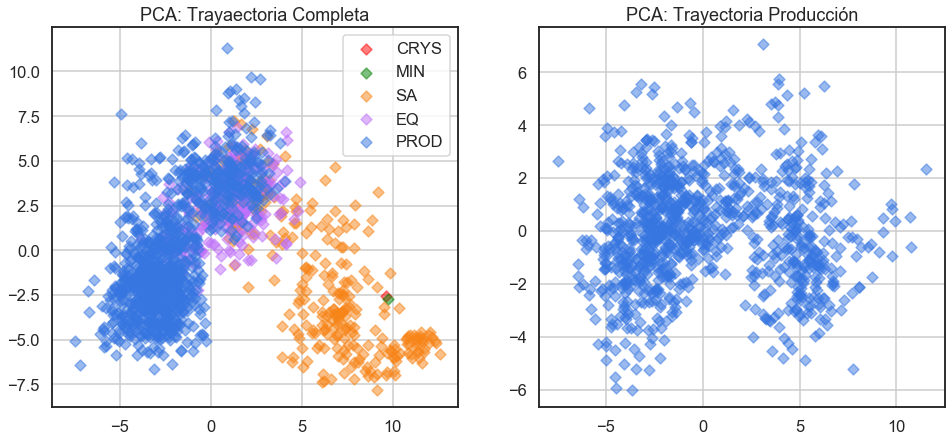

In [22]:
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
colors = ['red', 'green', '#F78417', '#BF71F9', '#3776E1']

for phase, f_range, color in \
    zip(dic_n_frames_by_phase.keys(), dic_n_frames_by_phase.values(), colors):
    plt.scatter(x = pca_full_traj['pca'].T[0][f_range],  
                y = pca_full_traj['pca'].T[1][f_range], marker = 'D', s =  60, 
               alpha = 0.5, label = phase.upper(), c = color)
plt.legend()
plt.title('PCA: Trayaectoria Completa')
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], marker = 'D', s =  60, 
            alpha = 0.5, label = phase.upper(), c = color)
plt.title('PCA: Trayectoria Producción')
plt.grid()

## Proyección de la trayectoria COMPLETA
A continuación proyectamos no sólo la producción, sino cada fase de la dinámica.

In [23]:
full_traj_4fku_projection = \
        get_sup_points_projected_mds(MDS_ref_object = mds_pisani_402, 
              traj_reference = traj_crystals, 
              # Las consf de prueba son un subconjunto de las de referencia
              traj_out_of_sample = traj_full_4fku, 
              ref = 0, n_components = 2)

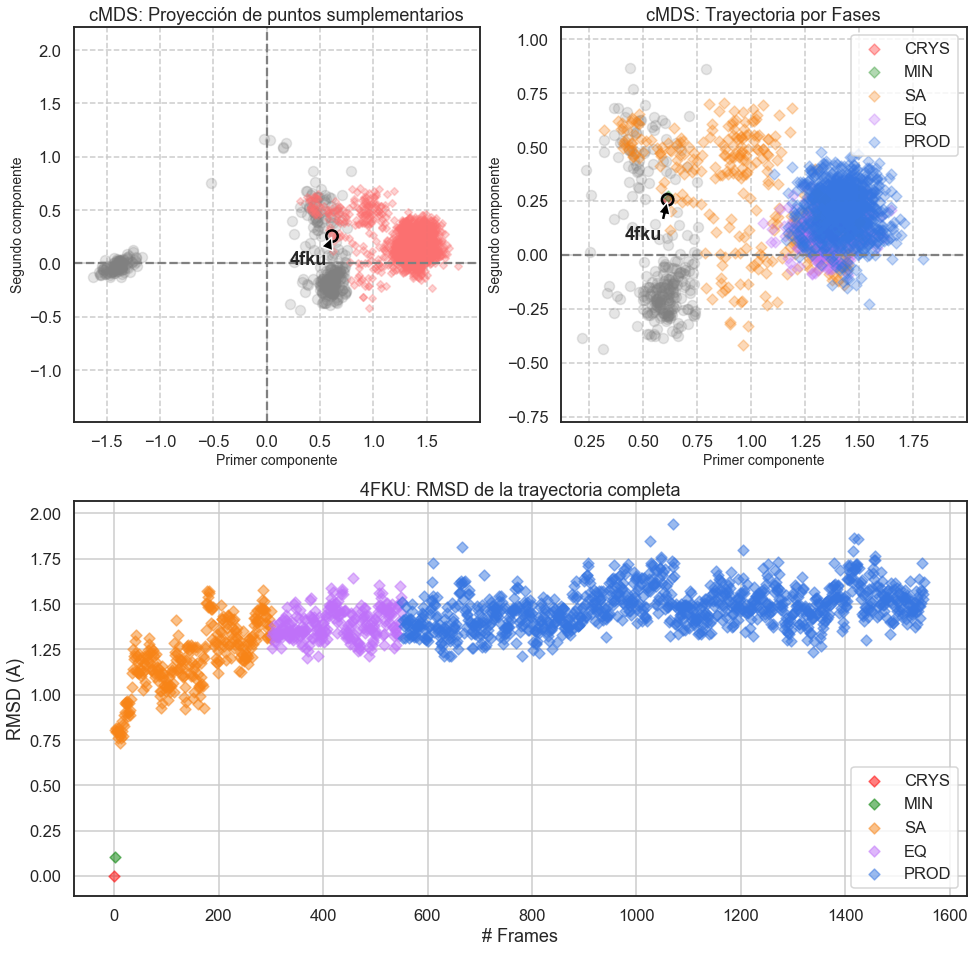

In [24]:
from miscellanious_traj_functions import example_traj_projection
example_traj_projection(Z = full_traj_4fku_projection, mds_pisani_402 = mds_pisani_402,
                            sistema = '4fku', df_prot = df_prot, rmsd_full_traj= rmsd_full_traj,
                            dic_n_frames_by_phase = dic_n_frames_by_phase, plot_points=plot_points,
                            plot_anotation_labels=plot_anotation_labels)

## Visualización con bokeh

Cargamos las librerías necesarias para bokeh.

In [25]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import Span, HoverTool, ColorBar, Legend, ResetTool
from bokeh.models import Range1d
from bokeh.transform import factor_cmap, LinearColorMapper
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from matplotlib import cm

In [26]:
# Datasource referencia

conformation_labels = df_prot.Labels_conf
conf_labels = conformation_labels.unique()

mds_total = mds_pisani_402
source_mds_ref = ColumnDataSource(data = dict(
    x = mds_total[0][0],
    y = mds_total[0][1],
    pdb_id = df_prot.index.to_series().apply(lambda x: x.upper()),
    conf_label = conformation_labels,
))

### Datasources de proyección
Creamos las paletas de colores para representar cada fase de las trayectorias.

In [27]:
# Dataframe con los datos de los puntos proyectados
color_maps = ['Dark2', 'Wistia', 'autumn', 'cool', 'winter']

labels_traj_by_phase = []
colors_phases = []
for f_range, label, color in zip(dic_n_frames_by_phase.values(), \
                                 dic_n_frames_by_phase.keys(), color_maps):
    n = len(f_range)
    labels_traj_by_phase = labels_traj_by_phase + [*np.repeat(label, n)]
    cmap = cm.get_cmap(color, n)
    colors_phases = colors_phases + [rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
# Se crea el dataframe
df_source_mds_proj = pd.DataFrame(dict(
                    x = full_traj_4fku_projection[0],
                    y = full_traj_4fku_projection[1],
                    md_phase = np.array(labels_traj_by_phase),
                    phase_colors = colors_phases
                ))

In [28]:
# Se crean los datasources de proyección
dic_datasources_proj = {key : df_source_mds_proj[df_source_mds_proj.md_phase == key]
                        for key in dic_n_frames_by_phase.keys()}

### Generamos el plot

In [29]:
# Hover sólo para conformaciones de referencia
HOVER = HoverTool(names=["ref"])
TOOLS = ['pan', 'wheel_zoom', HOVER, ResetTool()]
TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("PDB ID", "@pdb_id"),
    ("conf", "@conf_label"),
]
# Definición del plot
p = figure(tools=TOOLS, active_scroll='wheel_zoom', 
           match_aspect = True, plot_width = 900,  plot_height = 800,
           tooltips = TOOLTIPS,  title = "cMDS: 402 Conformaciones - Proyección",
           x_axis_label = 'Dimensión 1', y_axis_label = 'Dimensión 2')

# Proyección de los puntos de referencia
p_ref = p.scatter('x','y', source = source_mds_ref, name = 'ref',
          size = 15,
          fill_color='grey', fill_alpha=0.6,
          line_color=None)

# legend items
legend_items = []
# Proyección de las conformaciones de la trayectoria
p_projs_dic = {}
for phase, source_phase in dic_datasources_proj.items():
    p_proj =  p.scatter('x','y', source = source_phase,
                  size = 10, marker = 'diamond',
                  fill_color= 'phase_colors',
                  fill_alpha=1, line_color = None)
    x = source_phase.phase_colors
    # Adding colorbars
    if len(x) > 1:
        mapper = LinearColorMapper(palette = x, low=0, high= len(x))
        color_bar = ColorBar(color_mapper=mapper, title = phase,
                             location = (0, 0), height = 5, padding = 0,
                             orientation = 'horizontal')
        p.add_layout(color_bar, 'below')
    else:
        p_proj.glyph.line_color = 'black'
        p_proj.glyph.size = 8
        p_proj.glyph.marker = 'square'
    # update legend items
    legend_items.append( (phase, [p_proj]) )
    # add to the projs_dic
    p_projs_dic[phase] = p_proj
    
p.title.text_font_style = 'normal'
p.title.text_font_size = '2em'
p.title.align = 'center'

p.axis.axis_line_width = 3
p.axis.major_label_text_font_size = '11pt'

p.x_range = Range1d(-2, 2, bounds = (-2.5, 2.5))
p.y_range = Range1d(-1.0, 1.5, bounds= (-2, 1))

# Grid lines
p.grid.grid_line_color = 'black'
# Dashed grid
p.grid.grid_line_dash = [5, 3] # 5/2 line/space
p.grid.grid_line_alpha = 0.2

# y Grid area
    
# Legend 
legend = Legend(items = legend_items, location='top_left')
p.add_layout(legend)

# Vertical line
vline = Span(location=0, dimension='height', line_color='grey', line_width=3, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', line_color='grey', line_width=3, line_dash='dashed')
p.renderers.extend([vline, hline])

In [30]:
from bokeh.models.widgets import CheckboxGroup
from bokeh.models import CustomJS
from bokeh.layouts import WidgetBox,  row

checkbox = CheckboxGroup(labels = [*dic_n_frames_by_phase.keys()], 
                                  active = [0, 1, 2, 3, 4], width=50)
p_projs_dic['checkbox'] = checkbox

checkbox.callback = CustomJS.from_coffeescript(args = p_projs_dic,
                             code = """
crys.visible = 0 in checkbox.active;
min.visible = 1 in checkbox.active;
sa.visible = 2 in checkbox.active;
eq.visible = 3 in checkbox.active;
prod.visible = 4 in checkbox.active;
""")

In [31]:
output_notebook()
show(row(checkbox, p))

Loading BokehJS ...

## Clustering k-means y Clusteing Jerárquico

### Coordenadas en crudo (sin proporcionar matrices de distancias)

In [77]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [76]:
# Cálculo de la matriz de rmsd
traj_prod = traj_full_4fku[ -1000:]
# Convertimos la matriz de coordenadas a una matriz de dos dimensiones
traj_prod_2dxyz = traj_prod.xyz.reshape(traj_prod.n_frames, traj_prod.n_atoms * 3)

In [84]:
kmeans_prod_raw = KMeans(n_clusters=5).fit(traj_prod_2dxyz)

h_clust_raw = AgglomerativeClustering(n_clusters=5).fit(traj_prod_2dxyz)

In [87]:
distances = pyt.pairwise_rmsd(traj_prod)

In [90]:
kmeans_prod_rmsd = KMeans(n_clusters=5).fit(distances)

h_clust_rmsd = AgglomerativeClustering(n_clusters=5, linkage='complete',
                                      affinity='precomputed').fit(distances)

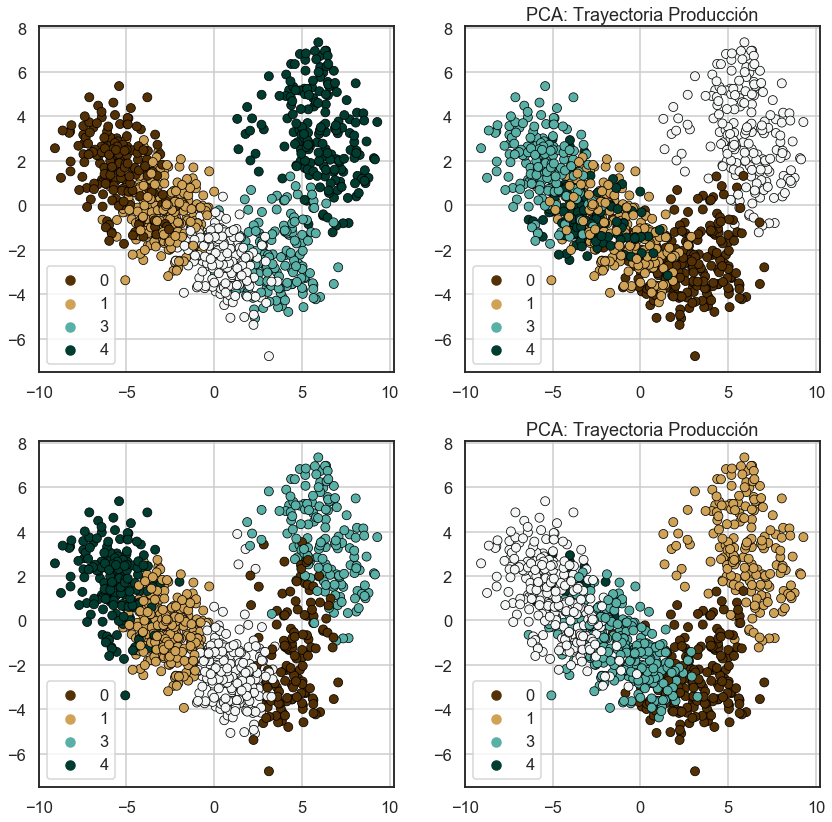

In [93]:
fig = plt.figure(figsize=(14, 14))
plt.subplot(2, 2, 1)
plt.grid()
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
                y = pca_prod_traj['pca'].T[1], 
                hue = kmeans_prod_raw.labels_, palette = "BrBG", edgecolor = 'black')
plt.subplot(2, 2, 2)
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
                y = pca_prod_traj['pca'].T[1], 
                hue = h_clust_raw.labels_, palette = "BrBG", edgecolor = 'black')
plt.title('PCA: Trayectoria Producción')
plt.grid()
plt.subplot(2, 2, 3)
plt.grid()
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = kmeans_prod_rmsd.labels_, palette = "BrBG", edgecolor = 'black')
plt.subplot(2, 2, 4)
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = h_clust_rmsd.labels_, palette = "BrBG", edgecolor = 'black')
plt.title('PCA: Trayectoria Producción')
plt.grid()

### Con matriz de distanceia RMSD

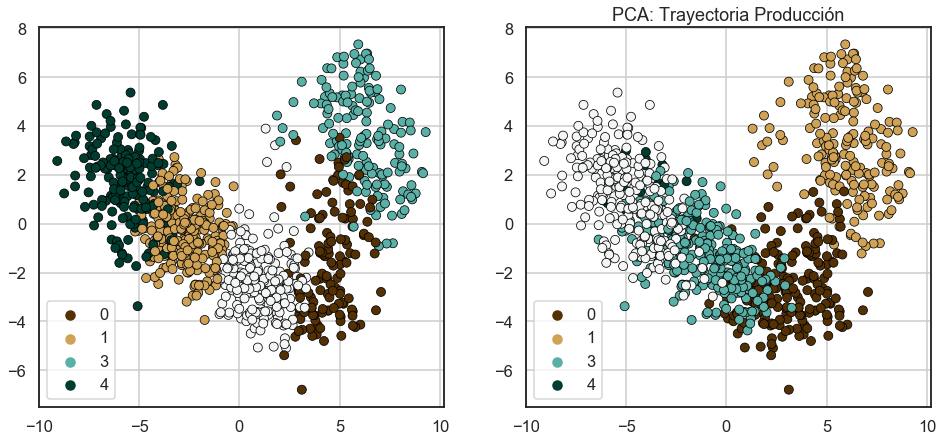

In [91]:
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.grid()
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = kmeans_prod_rmsd.labels_, palette = "BrBG", edgecolor = 'black')
plt.subplot(1, 2, 2)
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = h_clust_rmsd.labels_, palette = "BrBG", edgecolor = 'black')
plt.title('PCA: Trayectoria Producción')
plt.grid()

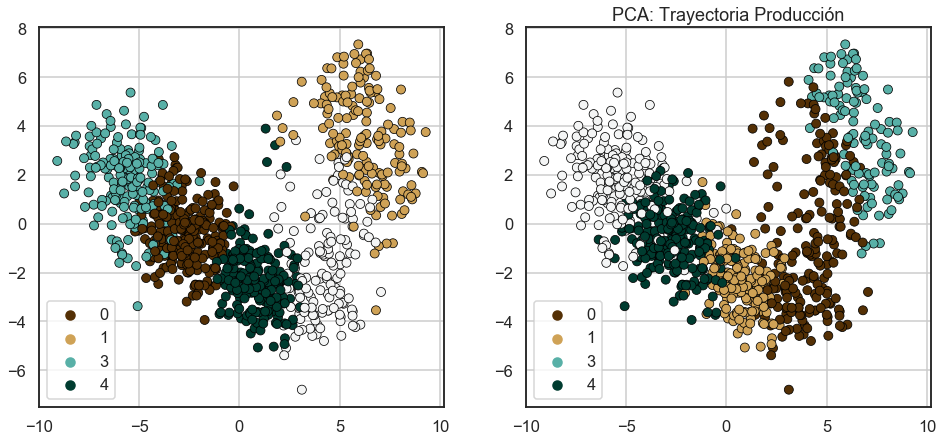

In [89]:
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.grid()
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = kmeans_prod_rmsd.labels_, palette = "BrBG", edgecolor = 'black')
plt.subplot(1, 2, 2)
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = h_clust_rmsd.labels_, palette = "BrBG", edgecolor = 'black')
plt.title('PCA: Trayectoria Producción')
plt.grid()

In [72]:
# Clustering Jerárquico
from sklearn.cluster import AgglomerativeClustering
h_clust = AgglomerativeClustering(n_clusters=5, linkage = 'ward').fit(
    traj_full_4fku[ -1000:].xyz.reshape(traj_full_4fku[ -1000:].n_frames, 
                                        traj_full_4fku[ -1000:].n_atoms * 3))

In [ ]:
# Clustering Jerárquico
from sklearn.cluster import AgglomerativeClustering
h_clust = AgglomerativeClustering(n_clusters=5, linkage = 'ward').fit(
    traj_full_4fku[ -1000:].xyz.reshape(traj_full_4fku[ -1000:].n_frames, 
                                        traj_full_4fku[ -1000:].n_atoms * 3))

In [ ]:
# Clustering K-medias
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(traj_full_4fku[ -1000:].xyz.reshape(traj_full_4fku[ -1000:].n_frames, 
                                        traj_full_4fku[ -1000:].n_atoms * 3))

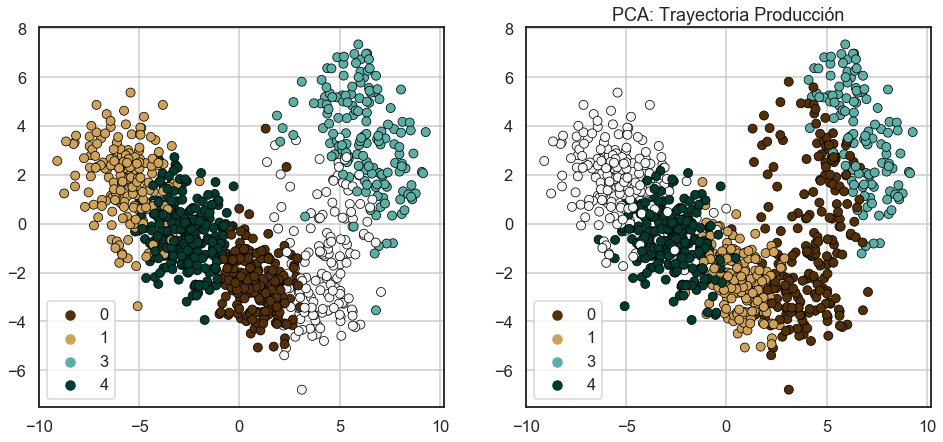

In [65]:
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.grid()
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = kmeans.labels_, palette = "BrBG", edgecolor = 'black')
plt.subplot(1, 2, 2)
sns.scatterplot(x = pca_prod_traj['pca'].T[0],  
            y = pca_prod_traj['pca'].T[1], 
            hue = h_clust.labels_, palette = "BrBG", edgecolor = 'black')
plt.title('PCA: Trayectoria Producción')
plt.grid()

In [34]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Slider, CheckboxGroup, CustomJS, ColumnDataSource, CDSView
from bokeh.models.filters import CustomJSFilter
from bokeh.layouts import row
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10_10
output_notebook()

Loading BokehJS ...

In [35]:
iris.flowers

NameError: name 'iris' is not defined

In [ ]:
from bokeh.sampledata import iris
source = ColumnDataSource(data=iris.flowers)
source_1 = ColumnDataSource(data=iris.flowers)
species = iris.flowers.species.unique().tolist()
checkboxes = CheckboxGroup(labels=species, active=list(range(len(species))))
fig = figure()
filter =  CustomJSFilter(code="""
let selected = checkboxes.active.map(i=>checkboxes.labels[i]);
let indices = [];
let column = source.data.species;
for(let i=0; i<column.length; i++){
    if(selected.includes(column[i])){
        indices.push(i);
    }
}
return indices;
""", args=dict(checkboxes=checkboxes, source=source))

checkboxes.js_on_change("active", CustomJS(code="source.change.emit();", args=dict(source=source)))

a = fig.scatter("sepal_length", "sepal_width", 
            color=factor_cmap("species", Category10_10, species),
            source=source, view=CDSView(source=source, filters=[filter]))

show(row(checkboxes, fig))

In [ ]:
import numpy as np

from bokeh.io import output_file, show
from bokeh.layouts import row
from bokeh.palettes import Viridis3
from bokeh.plotting import figure
from bokeh.models import CheckboxGroup, CustomJS



p = figure()
props = dict(line_width=4, line_alpha=0.7)
x = np.linspace(0, 4 * np.pi, 100)
l0 = p.line(x, np.sin(x), color=Viridis3[0], legend="Line 0", **props)
l1 = p.line(x, 4 * np.cos(x), color=Viridis3[1], legend="Line 1", **props)
l2 = p.line(x, np.tan(x), color=Viridis3[2], legend="Line 2", **props)

checkbox = CheckboxGroup(labels=["Line 0", "Line 1", "Line 2"],
                         active=[0, 1, 2], width=100)
checkbox.callback = CustomJS(args=dict(l0=l0, l1=l1, l2=l2, checkbox=checkbox),
                              code="""
l0.visible = 0 in checkbox.active;
l1.visible = 1 in checkbox.active;
l2.visible = 2 in checkbox.active;
""")

layout = row(checkbox, p)
show(layout)

In [ ]:
sns.palplot(sns.diverging_palette(220, 20, n=7))

In [ ]:
a = np.array([1, 2, 3, 4])
a[:-2]

**Minimización**

In [ ]:
min_traj_4fku_path = glob.glob(
    os.path.join(DM_DIR, system, md_type, 'rep_1', '1_min', F'{file_basename}.rst7'))[0]
sa_traj_4fku_path = glob.glob(
    os.path.join(DM_DIR, system, md_type, 'rep_1', F'{file_basename}.rst7'))[0]

ninguna de las funciones de procesamiento aplican ninguna máscara, con lo cual, las trayectorias de entrada con ñas que trabajan deben tener sólo los átomos con los que se quiere trabajar, y éstas deben tener el mismo número de átomos para la conformación de referencia, la trayectoria de referencia, y las trayectorias a procesar.

In [ ]:
[pyt.iterload(traj, prmtop_files[0]) for traj in nc_files]

In [ ]:
s[:, 0:2 ].T.shape

In [ ]:
mds_total[0].shape

In [ ]:
# Prueba de get_sup_rmsd_pairwise con los cristales
from modules.MDS import cMDS_proj
D_sup = get_sup_rmsd_pairwise(traj_crystals, traj_crystals[:])

s = cMDS_proj(mds_total, D_sup)

ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")

plt.scatter(s[:, :2].T[0], s[:, 1], marker = 'D', c = 'None', edgecolors='black', s = 20)
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

In [ ]:
def process_trajectory(system, md_type, file_basename, mask, 
                       obj_mds, traj_reference,
                       prod_dir = '4_prod', system_dir = DM_DIR):
    # OJO: La máscara debe ser aplicada una sola vez

    # Carga de la estructura de referencia, se extrae por default de la rep_1
    sytem_path = os.path.join(system_dir, system, md_type)
    ref_rst7 = glob.glob(os.path.join(sytem_path, 'rep_1', F'{file_basename}.rst7'))[0]
    ref_prmtop = glob.glob(os.path.join(sytem_path, 'rep_1', F'{file_basename}.prmtop'))[0]
    ref_conf = pyt.load(filename = ref_rst7, top = ref_prmtop,
                        # Seleccionamos únicamente la proteína
                         mask = mask)
    
    # Generamos el path de las conformaciones
    # Cargamos todas las trayectorias en  orden alfanumérico
    prmtop_files = sorted(glob.glob(os.path.join(sytem_path, 
                                             'rep_*', prod_dir, 'CA*prmtop')))
    nc_files = sorted(glob.glob(os.path.join(sytem_path, 
                                             'rep_*', prod_dir, 'CA*_prod.nc')))
    print(ref_conf)
    
    # Lista de trayectorias
    traj_list = [pyt.iterload(traj, prmtop_files[0]) for traj in nc_files]
    # En este punto a las trayectorias no se le han aplicado la máscara
    
    # Diccionario de trayectorias
    # Todas son superpuestas a la conformación inicial, y se aplica la máscara
    dic_trajs = {F'rep_{i+1}': 
                 traj_list[i][mask].superpose(ref = ref_conf)
                 for i in range (len(traj_list))}
    print(traj_list)
    
    # Cálculo del Rmsd por replica, almacenado en un dataFrame
    pd_rmsd = pd.DataFrame({key: pyt.rmsd(traj, 
                    ref = ref_conf) 
                    for key, traj in dic_trajs.items()})
    
    # Se obtienen los PCA independientes (por replica) usando sklearn
    # Los pca independientes no tienen superposición con el frame inicial
    dic_pca_traj = {key: process_pca(traj, ref = 0, n_vecs = 2) 
                for key, traj in dic_trajs.items()}
    
    # Se crea una trayectoria única, tomando como conformación inicial
    # la conformación de referencia
    full_traj = ref_conf.copy()
    
    for traj in traj_list:
        # Se plica la máscara porque en cada traj de traj_list no se había aplicado
        full_traj.append_xyz(traj[mask].xyz) 
    
    # PCA total
    pca = process_pca(full_traj, ref = 0,  n_vecs = 2)
    
    # MDS proyección a un espacio de REFERENCIA por trayectoria
    # 1) Se obtiene la  matriz suplementaria para cada traj
    dic_mds_sup_projections = {key: 
                               get_projected_points_mds(obj_mds, traj_reference = traj_reference,
                                                     traj_out_of_sample = traj) 
                for key, traj in dic_trajs.items()}
    
    return(dic_mds_sup_projections)

In [ ]:
%%time
a = process_trajectory(system = '4fku', md_type = 'mix_solv', 
                       file_basename = 'mxs_cdk2', mask = mask_pisani,
                      obj_mds = mds_total, traj_reference= traj_crystals)
a

In [ ]:
a['rep_1']

In [ ]:
# Prueba de get_sup_rmsd_pairwise con los cristalesNew
from modules.MDS import cMDS_proj
D_sup = get_sup_rmsd_pairwise(traj_crystals, traj_crystals[:])

s = cMDS_proj(mds_total, D_sup)

ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_points(mds = a['rep_1'], alpha=0.8)
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

In [ ]:
len(a['pcs'][0])

In [ ]:
# Primer sitema a evaluar
path_4fku_mxs_plain = os.path.join(DM_DIR, '4fku', 'mix_solv')
mask = F"(:{pisiani_residues})&(@CA)"
ref_conf = ref_conf_4fku

# Cargamos todas las trayectorias
prmtop_files = sorted(glob.glob(os.path.join(path_4fku_mxs_plain, 'rep_*', '4_prod', 'PROT*prmtop')))
nc_files = sorted(glob.glob(os.path.join(path_4fku_mxs_plain, 'rep_*', '4_prod', 'PROT*_prod.nc')))

# Lista de trayectorias
traj_list = [pyt.iterload(i, prmtop_files[0]) for i in nc_files]

# Diccionario de trayectorias
dic_trajs = {F'rep_{i+1}': traj_list[i].superpose(ref = ref_conf, 
                                                mask = mask)
             for i in range (len(traj_list))}
# Cálculo del Rmsd por replica
dic_rmsd = {key: pyt.rmsd(traj, ref = ref_conf,  mask = mask) 
                for key, traj in dic_trajs.items()}
# Se obtienen los PCA independientes (por replica)
dic_pca_traj = {key: pyt.pca(traj, mask = mask, n_vecs = 2) 
                for key, traj in dic_trajs.items()}

# Se crea una trayectoria única
# Creamos una tryectoria unica
full_traj = ref_conf_4fku.copy()
for traj in traj_list:
    full_traj.append_xyz(traj.xyz)
# Superposición hacia el frame de referencia
full_traj.superpose(ref = ref_conf, mask = mask)

# pca
pca = pyt.pca(full_traj, mask = mask)

# Cálculo de la amtriz de rmsd
distances = pyt.pairwise_rmsd(full_traj, mask = mask)

# Clustering Jerárquico

In [ ]:
import matplotlib.pyplot as plt
from modules.plotting_functions import plot_points, plot_anotation_labels
import seaborn as sns
import pylab
sns.set(context = 'talk', style = 'ticks')

In [ ]:
a['pca'][:,0]

In [ ]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = a['pca'][:,0], 
                    y = a['pca'][:,1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal');


In [ ]:
pca = pyt.pca(full_traj, mask = mask)

In [ ]:
pca.explained_variance_ratio_*100

In [ ]:
[i/sum(pca[1][0]) for i in pca[1][0]]

In [ ]:
# Gráfica de los RMSD
fig = plt.figure(figsize=(18, 5))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
counter = 0
for key, rmsd in dic_rmsd.items():
    sns.lineplot(x = range(len(rmsd)), y = rmsd, label = key, 
                 linewidth = 1.8, color = colors_list[counter])
    counter += 1
plt.ylim(bottom = 0, top = 5)
plt.grid(linestyle='--')

# Plots de PCA
fig, ax = plt.subplots(figsize=(20, 5))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
for i in range(1, 6):
    plt.subplot(1, 5, i)
    data = dic_pca_traj[F'rep_{i}'][0]
    ax = sns.scatterplot(x = data[0], y = data[1], 
                         alpha=0.6, label = F'rep_{i}',
                         linewidth=0, color = colors_list[i-1])
    plt.axis('square');

In [ ]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = pca[0][0, (i*1000)+1: ((i+1)*1000)+1], 
                    y = pca[0][1, (i*1000)+1: ((i+1)*1000)+1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0, color = colors_list[i])
ax = sns.scatterplot(x = pca[0][0, 0:1], y = pca[0][1, 0:1], color = 'green', linewidth=2)
ax = sns.scatterplot(x = pca[0][0, cluster_data.centroids], 
                     y = pca[0][1, cluster_data.centroids], color = 'yellow', alpha = 1, linewidth=2)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal');


In [ ]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = pca[0][0, (i*1000)+1: ((i+1)*1000)+1], 
                    y = pca[0][1, (i*1000)+1: ((i+1)*1000)+1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0, color = colors_list[i])
ax = sns.scatterplot(x = pca[0][0, 0:1], y = pca[0][1, 0:1], color = 'yellow')
ax = sns.scatterplot(x = pca[0][0, cluster_data.centroids], 
                     y = pca[0][1, cluster_data.centroids], color = 'yellow', alpha = 0.6)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.grid(linestyle='--')
plt.axis('equal');


In [ ]:
full_traj.superpose(ref = ref_conf_4fku, mask = F"(:{pisiani_residues})&(@CA)")

In [ ]:
# pca
pca = pyt.pca(full_traj, mask = F"(:{pisiani_residues})&(@CA)", n_vecs = 2) 

In [ ]:
pca[0][1, 0]

In [ ]:
full_traj.superpose(ref = ref_conf_4fku, mask = F"(:{pisiani_residues})&(@CA)")
pca_pk = pyt.pca(full_traj, mask = F"(:{pocket_residues})&(@CA)", n_vecs = 2) 

In [ ]:
# pcoket
fig, ax = plt.subplots(figsize=(8, 8))
colores = ['Purples', 'Reds', 'Greens', 'Blues', 'Greys']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = pca_pk[0][0, (i*1000)+1: ((i+1)*1000)+1], 
                    y = pca_pk[0][1, (i*1000)+1: ((i+1)*1000)+1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0)
ax = sns.scatterplot(x = pca_pk[0][0, 0:1], y = pca_pk[0][1, 0:1], color = 'yellow')
ax = sns.scatterplot(x = pca_pk[0][0, cluster_data.centroids], 
                     y = pca_pk[0][1, cluster_data.centroids], color = 'yellow', alpha = 0.6)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

In [ ]:
# Clustering
import scipy
import scipy.cluster.hierarchy

# Cálculo de la amtriz de rmsd
distances = pyt.pairwise_rmsd(full_traj, mask = F"(:{pisiani_residues})&(@CA)")

In [ ]:
linkage = scipy.cluster.hierarchy.ward(distances)

scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')
None

In [ ]:
# Clustering con sklearn
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(distances)

In [ ]:
sum(ward.labels_ == 3)
ward

In [ ]:
%%time
# con kmeans de sklearn
from sklearn.cluster import KMeans
distances = pyt.pairwise_rmsd(full_traj, mask = F"(:{pisiani_residues})&(@CA)")
kmeans = KMeans(n_clusters=5).fit(distances)

In [ ]:
centroids = kmeans.cluster_centers_
centroids[:, 0]

In [ ]:
sum(kmeans.labels_ == 1)

In [ ]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x = pca[0][0], 
                    y = pca[0][1], hue = kmeans.labels_,
                    alpha=0.4, label = F'rep_1', linewidth=0)
ax = sns.scatterplot(x = pca[0][0, 0:1], y = pca[0][1, 0:1], color = 'yellow')
ax = sns.scatterplot(x = pca[0][0, cluster_data.centroids], 
                     y = pca[0][1, cluster_data.centroids], color = 'yellow', alpha = 0.6)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal');

In [ ]:
%%time
# Clusterign con kmeans
cluster_data = pyt.cluster.kmeans(full_traj, mask = F"(:{pisiani_residues})&(@CA)", 
                                  n_clusters = 5)

In [ ]:
cluster_data.cluster_index == 1

In [ ]:
cluster_data.centroids